In [1]:
import matplotlib.pyplot as plt
import neurolib.utils.functions as func
import numpy as np
from IPython.display import display
from neurolib.models.multimodel import (
    ALNNode,
    FitzHughNagumoNetwork,
    FitzHughNagumoNode,
    MultiModel,
)
from neurolib.optimize.evolution import Evolution
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.parameterSpace import ParameterSpace

# a nice color map
plt.rcParams["image.cmap"] = "plasma"

# `MultiModel` advanced topics
In the last two examples we showcased the basics of `MultiModel` framework and how to create a new model from scratch. Now we will look at some advanced topics such as how exactly the integration works, why we have two integration backends, and how to run optimisation and exploration with `MultiModel`.

## The tale of two backends
In the current implementation of `MultiModel`, users may choose from two different integration backends. Before diving into the details of both backends, let us quickly revise how exactly `MultiModel` integrates the model equations.

### The how
Almost all whole-brain simulators works in the sense, that you define the dynamics of single brain area and then we have a double loop for integration: one over time, the second over brain areas. In other words, all brain areas have the same dynamics. In pseudo-code it would look something like:
```python
for t in range(time_total):
    for n in range(num_areas):
        x[t, n] = integrate_step(x[t-max_delay:t-1, :])
```
Since all areas are the same, the `integrate_step` function would simply take the history of state vector and apply one integration step in any scheme. This won't work in `MultiModel`, since it allows building heterogeneous models. The internal workings of `MultiModel` can be explained in couple of steps.

#### State vector
Since the inner loop in the pseudocode above is not doable in `MultiModel` due to heterogeneity, we solve it simply by concatenating all individual equations into one big state vector (that is also the reason why all `NeuralMass` and `Node` objects have their indices). When the model is ready for simulation, we iterate over `Nodes` and `NeuralMasses` within these nodes and stack their equations into a single list. The concatenation is done using the `_derivatives()` function.
- in `NeuralMass`, the `_derivatives()` function implements the actual dynamics as delay differential equations
- in `Node`, the `_derivatives()` function stacks all equations from `NeuralMasses` within this `Node` into one list
- in `Network`, the `_derivatives()` function stacks all equations from `Nodes` within this `Network`.

Let us see how it looks like:

In [2]:
# create a FitzHugh-Nagumo Node
fhn_node = FitzHughNagumoNode()
# necessary attributes when creating a Node from scratch
fhn_node.index = 0
fhn_node.idx_state_var = 0
fhn_node.init_node()

display(fhn_node._derivatives())
display(len(fhn_node._derivatives()), fhn_node.num_state_variables)

[1.0 + 4.0*current_y(0)**2 - 3.0*current_y(0)**3 - 1.5*current_y(0) - current_y(1) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)),
 0.05*(current_y(0) - 0.5*current_y(1)) + past_y(-external_input + t, 1 + input_base_n, anchors(-external_input + t))]

2

2

As we see, the `_derivatives()` function return a list of equations, in this case of length 2 (which is, of course, equal to `fhn.num_state_variables`). The `current_y(<index>)` lingo is taken from `jitcdde`. As written above, all equations are symbolic and therefore `current_y(<index>)` is a `symengine` `Symbol` representing state vector with index `<index>` at current time `t`. In other words, `current_y(0)` is the first variable (in FitzHugh-Nagumo model, this is the $x$), while `current_y(1)` is the second variable (the $y$). The `past_y()` lingo is the same, but encodes either the past of the state vector, i.e. delayed interactions, or the external input (noise or stimulus). In this case it represents the external input (you can tell since it is `past_y(-external_input...)`). Now let us see how it looks like for network:

In [3]:
# create 2 node FHN network
SC = np.array([[0.0, 1.43], [0.64, 0.0]])
delays = np.array([[0.0, 10.0], [10.0, 0.0]])
fhn_net = FitzHughNagumoNetwork(SC, delays)

display(len(fhn_net._derivatives()), fhn_net.num_state_variables)
display(fhn_net._derivatives())

4

4

[1.0 + network_x_0 + 4.0*current_y(0)**2 - 3.0*current_y(0)**3 - 1.5*current_y(0) - current_y(1) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)),
 network_y_0 + 0.05*(current_y(0) - 0.5*current_y(1)) + past_y(-external_input + t, 1 + input_base_n, anchors(-external_input + t)),
 1.0 + network_x_1 + 4.0*current_y(2)**2 - 3.0*current_y(2)**3 - 1.5*current_y(2) - current_y(3) + past_y(-external_input + t, 2 + input_base_n, anchors(-external_input + t)),
 network_y_1 + 0.05*(current_y(2) - 0.5*current_y(3)) + past_y(-external_input + t, 3 + input_base_n, anchors(-external_input + t))]

Now, since we have 2 nodes, the total number of state variables is 4. And now, we see equations for the whole network as a list of 4 symbolic equations. In the network equations we see a new symbol: `network_x_0` and `network_x_1`. At this time, these are really just `symengine` symbols, but they actually represent the coupling between the nodes. And that is also a topic of the next section.

#### Coupling
As we have seen before, the state vector encodes the whole dynamics of the brain model, but the coupling is crypted as symbol. To make things easier for simulating, we had to separate the individual internal dynamics from the coupling terms. The coupling comes in two flavours, reflecting the three levels of hierarchy: node coupling takes care of coupling between `NeuralMasses` within one `Node`, and network coupling takes care of coupling between `Nodes` in one `Network`. The coupling is implemented as `_sync()` function. This function returns a list, where each item is a tuple of length two: `(name_of_the_symbol, symbolic_term_representing_the_coupling)`. The FitzHugh-Nagumo model only has one mass per node, hence there are no node couplings, but we can inspect the network coupling:

In [4]:
display(fhn_net._sync())

[(network_x_0,
  1.43*(-current_y(0) + past_y(-10.0 + t, 2, anchors(-10.0 + t)))),
 (network_x_1,
  0.64*(-current_y(2) + past_y(-10.0 + t, 0, anchors(-10.0 + t)))),
 (network_y_0, 0.0),
 (network_y_1, 0.0)]

In this particular case, we have 2 coupling variables and 2 nodes, hence 4 coupling terms. The coupling of $y$ is zero. As per the coupling of $x$ variables between nodes, you can now see how it works: `network_x_0` just means that we are about to define a network coupling of variable `x` for the first node, and it is just 1.43 (this is the SC matrix we passed when creating FHN network) times state variable with index 2 at time -10 milliseconds minus current state variable index 0 (diffusive coupling). Similarly for node 1 (with different coupling strength and state variable indices, of course).

Now when symbols from `_sync()` function are inserted into `_derivatives()` at the proper places, we have a full definition of a model. This is exactly what both backends do: they gather the equations (`_derivatives()`), look up the coupling terms (`_sync()`) and integrate the model forward in time.

### `jitcdde` backend
The `jitcdde` backend was the first integration backend in `MultiModel`. The name stems from the fact that we use wonderful [`jitcdde`](https://jitcdde.readthedocs.io/en/stable/) python package. It employs just-in-time compilation of symbolic derivatives into C and then uses DDE integration method proposed by Shampine and Thompson, which in turn employs the Bogacki–Shampine Runge–Kutta pair. This is the reason why the definition of dynamics in `MultiModel` is done using symbolic derivatives written in `symengine`. It uses adaptive `dt` scheme, hence is very useful for stiff problems. Also, if you are implementing a new model and have no idea how stiff the dynamics are, this is the backend to try first. It has reasonable speed, but for large networks and long simulations it is not the best.

The internal workings of `jitcdde` package served as an inspiration when creating `MultiModel`. `jitcdde` naturally works with dynamics defined as symbolic equations (`_derivatives()`) and it also supports the use of "helpers" - the helpers in our case are the coupling terms (`_sync()`).

/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
100%|██████████| 2000/2000 [00:00<00:00, 85415.01it/s]

Using default integration parameters.


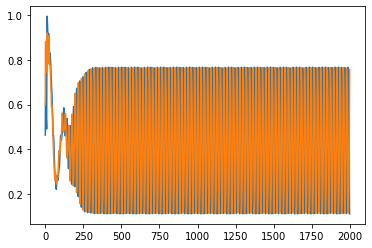

In [5]:
fhn_mm = MultiModel(fhn_net)
# 2 second run
fhn_mm.params["duration"] = 2000.0
fhn_mm.params["backend"] = "jitcdde"
# jitcdde works with adaptive dt, you only set sampling dt
fhn_mm.params["sampling_dt"] = 1.0
fhn_mm.run()

plt.plot(fhn_mm.x.T)

### `numba` backend
Since `jitcdde` is rather slow, in particular for long runs or large networks, we created a `numba` backend. It was tricky - the whole code around `MultiModel` was creating with `jitcdde` in mind with the symbolic equations, helpers, etc. However, the advantage of symbolic equations is also - they are purely symbolic, so you can "print" them. By printing, you really just obtain the string with equations. So what `numba` backend actually does?
1. gather all symbolic equations with `_derivatives()`
2. substitute coupling symbols with functional terms in `_sync()`
3. substitute current and past state vector symbols (`current_y()` and `past_y()`) with state vector `y` with correct indices and time delays
4. now we have a complete description of `dy`
5. "print" out this `dy` into prepared function template (string) inside the time for loop, you can imagine it as
```python
for t in range(1, t_max):
      dy = np.array({dy}) # <- `dy` is printed here
      y[:, t] = y[:, t-1] + dt*dy
```
6. compile the prepared string template into an actual python function (yes, python can do this)
7. wrap the compiled function with `numba.njit()` to get the speed boots
8. profit

And yes, the `numba` backend simply employs Euler integration scheme, which means that you need to think about dt.

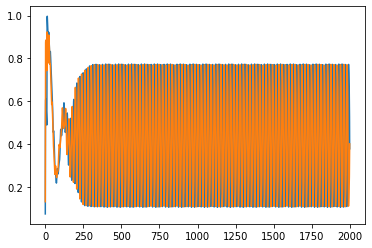

In [6]:
fhn_mm = MultiModel(fhn_net)
# 2 second run
fhn_mm.params["duration"] = 2000.0
fhn_mm.params["backend"] = "numba"
# numba uses Euler scheme so dt is important!
fhn_mm.params["dt"] = 0.1
fhn_mm.params["sampling_dt"] = 1.0
fhn_mm.run()

plt.plot(fhn_mm.x.T)

## Which backend to use and when?
By default `numba` backend is almost always faster (with the exception of small network and not too long runs, when they perform similarly). However, for prototyping new models, or connecting couple of models into a heterogeneous network, it is always a good idea to do a couple of short simulations with `jitcdde`. The reason is - it uses an adaptive dt, so you do not need to worry about setting a correct dt. When you have an idea about what the dynamics should look like and how fast it is, you can switch to `numba` and try couple of different dt and select the one, when the results are closest to `jitcdde` results. For exploration and optimisation with evolution, always use `numba`. `numba` backend is actually compiling a jit'ed function with all the parameters as arguments, hence for exploration, only one compilation is necessary and then even when changing parameters, the model runs at high speed.

## Exploration with `MultiModel`

So we all love `neurolib` not only for its speed, efficiency, and ease of use, but also for its built-in exploration and evolution frameworks. These two makes studying the population models a real breeze! And naturally, `MultiModel` supports both. Firtsly, we will showcase how we can explore parameters of `MultiModel` using the `BoxSearch` class and we will replicate the ALN exploration from `example-1-aln-parameter-exploration.ipynb`.

In [7]:
# first init multimodel
aln_mm = MultiModel.init_node(ALNNode())
display(aln_mm.params)

{'ALNNode_0.ALNMassEXC_0.Ke': 800.0,
 'ALNNode_0.ALNMassEXC_0.Ki': 200.0,
 'ALNNode_0.ALNMassEXC_0.c_gl': 0.4,
 'ALNNode_0.ALNMassEXC_0.Ke_gl': 250.0,
 'ALNNode_0.ALNMassEXC_0.tau_se': 2.0,
 'ALNNode_0.ALNMassEXC_0.tau_si': 5.0,
 'ALNNode_0.ALNMassEXC_0.sigmae_ext': 1.5,
 'ALNNode_0.ALNMassEXC_0.Jee_max': 2.43,
 'ALNNode_0.ALNMassEXC_0.Jei_max': -3.3,
 'ALNNode_0.ALNMassEXC_0.C': 200.0,
 'ALNNode_0.ALNMassEXC_0.gL': 10.0,
 'ALNNode_0.ALNMassEXC_0.ext_exc_current': 0.0,
 'ALNNode_0.ALNMassEXC_0.ext_exc_rate': 0.0,
 'ALNNode_0.ALNMassEXC_0.a': 15.0,
 'ALNNode_0.ALNMassEXC_0.b': 40.0,
 'ALNNode_0.ALNMassEXC_0.EA': -80.0,
 'ALNNode_0.ALNMassEXC_0.tauA': 200.0,
 'ALNNode_0.ALNMassEXC_0.lambda': 10.0,
 'ALNNode_0.ALNMassEXC_0.noise_0.type': 'OrnsteinUhlenbeckProcess',
 'ALNNode_0.ALNMassEXC_0.noise_0.mu': 0.4,
 'ALNNode_0.ALNMassEXC_0.noise_0.sigma': 0.0,
 'ALNNode_0.ALNMassEXC_0.noise_0.tau': 5.0,
 'ALNNode_0.ALNMassEXC_0.noise_0.num_iid': 1,
 'ALNNode_0.ALNMassEXC_0.noise_0.seed': None,
 '

### Note on parameters when exploring or optimising
If you remember, the `MultiModel` has an option for true heterogeneous parameters, i.e. each brain node can have different parameters. This allows you to explore paramaters one-by-one (truly different parameters for each node), or in bulk. As an example, consider this:
```python
parameters1 = ParameterSpace({"*Ke": [400, 800, 1200]}, allow_star_notation=True)

parameters2 = ParameterSpace(
    {"*EXC*Ke": [400, 800, 1200], "*INH*Ke": [400, 800, 1200]},
    allow_star_notation=True
)

parameters2 = ParameterSpace(
    {"*Node_0*EXC*Ke": [400, 800, 1200], "*Node_1*EXC*Ke": [400, 800, 1200]},
    allow_star_notation=True
)
```
In the first example (`parameters1`), we explore `Ke` parameter and set this for all nodes and for all masses the same. In the end, we run three simulations with homogeneous `Ke` for all nodes/masses.

In the second example, we explore `Ke` individually for excitatory masses and inhibitory masses, however, for all nodes these would be the same. In total, we will run 9 simulations with heterogeneous `Ke` within one node, but the same values for `Ke_exc` and `Ke_inh` would be used in all nodes.

Finally, in the last example, we would explore only excitatory `Ke` parameters, but for two nodes differently, hence we can study how excitatory `Ke` affects 2-node network.

Of course, we can always call parameters by their full name (glob path), like:
```python
parameters3 = ParameterSpace(
    {"ALNNode_0.ALNMassINH_1.Ke": [400, 800, 1200]},
    allow_star_notation=True # due to "." in the param names
)
```
and we will simply explore over one particular `Ke` of inhibitory mass in first node within a network. All other `Ke` parameters will remain constant.

In [8]:
# match params to core ALN model
aln_mm.params["backend"] = "numba"
aln_mm.params["dt"] = 0.1  # ms
aln_mm.params["*c_gl"] = 0.3
aln_mm.params["*b"] = 0.0
aln_mm.params["ALNNode_0.ALNMassEXC_0.a"] = 0.0

# set up exploration - using star

# parameters = ParameterSpace(
#     {
#         "*EXC*input*mu": np.linspace(0, 3, 21),
#         "*INH*input*mu": np.linspace(0, 3, 21),
#     },
#     allow_star_notation=True,
# )

# set up exploration - using exact parameter names
# in this case (one node, search over noise mu) -> these two are equivalent!
parameters = ParameterSpace(
    {
        # 2 values per dimension is for quick testing only, for real exploration use e.g. 21 or rather much more
        "ALNNode_0.ALNMassEXC_0.input_0.mu": np.linspace(0, 3, 2),
        "ALNNode_0.ALNMassINH_1.input_0.mu": np.linspace(0, 3, 2),
        # "ALNNode_0.ALNMassEXC_0.input_0.mu": np.linspace(0, 3, 21),
        # "ALNNode_0.ALNMassINH_1.input_0.mu": np.linspace(0, 3, 21),
    },
    allow_star_notation=True,
)
search = BoxSearch(aln_mm, parameters, filename="example-4.2-exploration.hdf")

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-4.2-exploration.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/pypet/naturalnaming.py:1473: SyntaxWarning: `lambda` is a python keyword, you may not be able to access it via natural naming but only by using `[]` square bracket notation. 
  category=SyntaxWarning)
MainProcess root INFO     Number of parameter configurations: 441
MainProcess root INFO     BoxSearch: Environment initialized.


In [9]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-07-07-16H-40M-57S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2021-07-07-16H-40M-57S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2021-07-07-16H-40M-57S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-07-07-16H-40M-57S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [10]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/example-4.2-exploration.hdf
MainProcess root INFO     Analyzing trajectory results-2021-07-07-16H-40M-57S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-4.2-exploration.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-07-07-16H-40M-57S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 441/441 [00:02<00:00, 219.34it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 441/441 [00:00<00:00, 3745.

In [11]:
print(f"Number of results: {len(search.results)}")

Number of results: 441


In [12]:
# Example analysis of the results
# The .results attribute is a list and can be indexed by the run
# number (which is also the index of the pandas dataframe .dfResults).
# Here we compute the maximum firing rate of the node in the last second
# and add the result (a float) to the pandas dataframe.
for i in search.dfResults.index:
    search.dfResults.loc[i, "max_r"] = np.max(
        search.results[i]["r_mean_EXC"][:, -int(1000 / aln_mm.params["dt"]) :]
    )

Text(0, 0.5, 'Input to I')

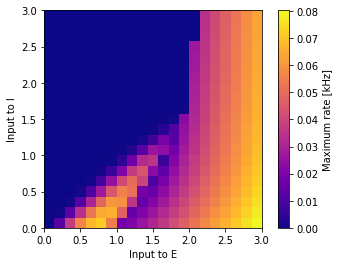

In [13]:
plt.imshow(
    search.dfResults.pivot_table(
        values="max_r",
        index="ALNNode_0.ALNMassINH_1.input_0.mu",
        columns="ALNNode_0.ALNMassEXC_0.input_0.mu",
    ),
    extent=[
        min(search.dfResults["ALNNode_0.ALNMassEXC_0.input_0.mu"]),
        max(search.dfResults["ALNNode_0.ALNMassEXC_0.input_0.mu"]),
        min(search.dfResults["ALNNode_0.ALNMassINH_1.input_0.mu"]),
        max(search.dfResults["ALNNode_0.ALNMassINH_1.input_0.mu"]),
    ],
    origin="lower",
)
plt.colorbar(label="Maximum rate [kHz]")
plt.xlabel("Input to E")
plt.ylabel("Input to I")

## Evolution with `MultiModel`

If you're familiar with how `Evolution` works in core `neurolib`, and now you know the perks of `MultiModel` with respect to exploration - that's all you need to know when doing optimisation using evolutionary algorithms using `MultiModel`. Parameters are passed via `ParameterSpace` with `allow_star_notation=True`. Below, we will reproduce the `example-2.1-evolutionary-optimization-aln` with the `MultiModel` version of ALN model.

In [14]:
# reinit fresh model
aln_mm = MultiModel.init_node(ALNNode())
# match params to core ALN model
aln_mm.params["backend"] = "numba"
aln_mm.params["dt"] = 0.1  # ms
aln_mm.params["*c_gl"] = 0.3
aln_mm.params["*b"] = 0.0
aln_mm.params["ALNNode_0.ALNMassEXC_0.a"] = 0.0

MainProcess root INFO     Loading precomputed transfer functions from /Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
MainProcess root INFO     All transfer functions loaded.
MainProcess root INFO     Loading precomputed transfer functions from /Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
MainProcess root INFO     All transfer functions loaded.
MainProcess root INFO     ALNNode: Model initialized.


In [15]:
# use the same loss function as example-2.1
def evaluateSimulation(traj):
    # The trajectory id is provided as an attribute
    rid = traj.id
    # this function provides the a model with the partuclar
    # parameter set for this given run
    model = evolution.getModelFromTraj(traj)
    # parameters can also be modified after loading
    model.params["dt"] = 0.1
    model.params["duration"] = 2 * 1000.0
    # and the simulation is run
    model.run()

    # compute power spectrum
    frs, powers = func.getPowerSpectrum(
        model.r_mean_EXC[:, -int(1000 / model.params["dt"]) :], dt=model.params["dt"]
    )
    # find the peak frequency
    domfr = frs[np.argmax(powers)]
    # fitness evaluation: let's try to find a 25 Hz oscillation
    fitness = abs(domfr - 25)
    # deap needs a fitness *tuple*!
    fitness_tuple = ()
    # more fitness values could be added
    fitness_tuple += (fitness,)
    # we need to return the fitness tuple and the outputs of the model
    return fitness_tuple, model.outputs

In [16]:
pars = ParameterSpace(
    ["*EXC*input*mu", "*INH*input*mu"],
    [[0.0, 4.0], [0.0, 4.0]],
    allow_star_notation=True,
)
weightList = [-1.0]

evolution = Evolution(
    evalFunction=evaluateSimulation,
    parameterSpace=pars,
    model=aln_mm,  # use our `MultiModel` here
    weightList=[-1.0],
    # POP_INIT_SIZE=16,  # mutiple of number of cores
    # POP_SIZE=16,
    # low numbers for testing, for real evolution use higher number of runs
    POP_INIT_SIZE=4,  # mutiple of number of cores
    POP_SIZE=4,
    # low numbers for testing, for real evolution use higher number
    NGEN=2,
    filename="example-4.2-evolution.hdf",
)

MainProcess root INFO     Trajectory Name: results-2021-07-07-16H-45M-51S
MainProcess root INFO     Storing data to: ./data/hdf/example-4.2-evolution.hdf
MainProcess root INFO     Trajectory Name: results-2021-07-07-16H-45M-51S
MainProcess root INFO     Number of cores: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/example-4.2-evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x159a6df80>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x159a43560>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x159a70440>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x159a70170>
MainProcess root INFO     Evolution: Selection operator:

In [17]:
evolution.run(verbose=False)

MainProcess root INFO     Evaluating initial population of size 16 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-07-07-16H-45M-51S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2021-07-07-16H-45M-51S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2021-07-07-16H-45M-51S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO   

/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


> Simulation parameters
HDF file storage: ./data/hdf/example-4.2-evolution.hdf
Trajectory Name: results-2021-07-07-16H-45M-51S
Duration of evaluating initial population 0:00:11.681965
Duration of evolution 0:01:31.868614
Model: <class 'neurolib.models.multimodel.model.MultiModel'>
Model name: ALNNode
Eval function: <function evaluateSimulation at 0x15b06a830>
Parameter space: {'*EXC*noise*mu': [0.0, 4.0], '*INH*noise*mu': [0.0, 4.0]}
> Evolution parameters
Number of generations: 10
Initial population size: 16
Population size: 16
> Evolutionary operators
Mating operator: <function cxBlend at 0x159a43560>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x159a70200>
Selection paramter: {}
Parent selection operator: <function selRank at 0x159a70170>
Comments: no comments
--- Info summary ---
Valid: 16
Mean score (weighted fitness): -3.6
Parameter distribution (Generation 9):
STAREXCSTARnoiseSTARmu: 	 mean: 1.1141,	 std: 0.2046
STARINHSTARnoiseSTARmu: 	 mea

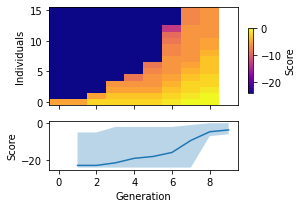

There are 16 valid individuals
Mean score across population: -3.6


MainProcess root INFO     Saving plot to ./data/figures/results-2021-07-07-16H-45M-51S_hist_9.png


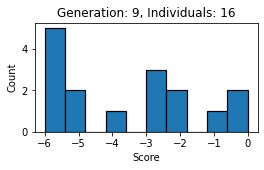

<Figure size 432x288 with 0 Axes>

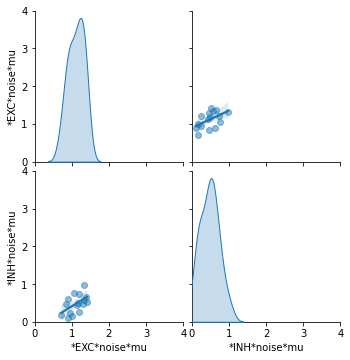

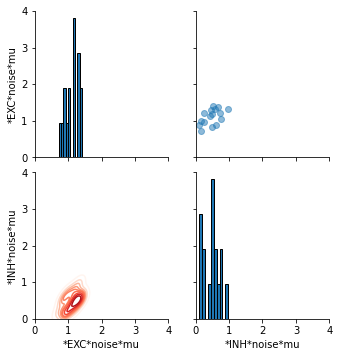

In [18]:
evolution.info(plot=True)

## Adapting existing models in `MultiModel` framework
`MultiModel` comes with a few implemented models so you can play with models right away. Due to the hierarchical architecture based on class inheritence in python, it is also very easy to adapt existing models. As an example - `MultiModel` comes with an implementation of Wilson-Cowan model. In our version, there are excitatory and inhibitory masses in one node. Let's say, you want to add an adaptation current inside excitatory mass in Wilson-Cowan model.

In [19]:
# imports
from jitcdde import input as system_input
from neurolib.models.multimodel.builder.base.constants import EXC
from neurolib.models.multimodel.builder.wilson_cowan import (
    WC_EXC_DEFAULT_PARAMS,
    WC_NODE_DEFAULT_CONNECTIVITY,
    ExcitatoryWilsonCowanMass,
    InhibitoryWilsonCowanMass,
    WilsonCowanNode,
)

Here is just a copy-paste code of ExcitatoryWilsonCowanMass:
```python
class ExcitatoryWilsonCowanMass(WilsonCowanMass):
    """
    Excitatory Wilson-Cowan neural mass.
    """

    name = "Wilson-Cowan excitatory mass"
    label = f"WCmass{EXC}"
    coupling_variables = {0: f"q_mean_{EXC}"}
    state_variable_names = [f"q_mean_{EXC}"]
    mass_type = EXC
    required_couplings = ["node_exc_exc", "node_exc_inh", "network_exc_exc"]

    def __init__(self, params=None, seed=None):
        super().__init__(params=params or WC_EXC_DEFAULT_PARAMS, seed=seed)

    def _derivatives(self, coupling_variables):
        [x] = self._unwrap_state_vector()
        d_x = (
            -x
            + (1.0 - x)
            * self._sigmoid(
                coupling_variables["node_exc_exc"]
                - coupling_variables["node_exc_inh"]
                + coupling_variables["network_exc_exc"]
                + self.params["ext_input"]
            )
            + system_input(self.noise_input_idx[0])
        ) / self.params["tau"]

        return [d_x]
```

Since everything in `MultiModel` is a class, we will simply subclass the `ExcitatoryWilsonCowanMass` and edit / add things we need to.

Our adaptation current will come in as:
$$\dot{w} = -\frac{w}{\tau_{A}} + b*r$$

In [20]:
class AdaptationExcitatoryWilsonCowanMass(ExcitatoryWilsonCowanMass):
    # here we only edit attributes that will change!
    # slightly edit name and label
    name = "Wilson-Cowan excitatory mass with adaptation"
    label = f"WCmass{EXC}_adapt"

    num_state_variables = 2
    # same number of noise variables

    # coupling variables - the same, no need to do anything
    # add w as a variable
    state_variable_names = [f"q_mean_{EXC}", "w"]
    # mass type and couplings are the same

    # add parameters for adaptation current - b and tauA
    required_params = ["a", "mu", "tau", "ext_drive", "b", "tauA"]

    # same input noise

    def __init__(self, params=None, seed=None):
        # edit init and pass default parameters for adaptation
        super().__init__(params=params or WC_ADAPT_EXC_DEFAULT_PARAMS, seed=seed)
        
    def _initialize_state_vector(self):
        # need to add init for adaptation variable w
        np.random.seed(self.seed)
        self.initial_state = [0.05 * np.random.uniform(0, 1), 0.0]

    def _derivatives(self, coupling_variables):
        # edit derivatives
        [x, w] = self._unwrap_state_vector()
        d_x = (
            -x
            + (1.0 - x)
            * self._sigmoid(
                coupling_variables["node_exc_exc"]
                - coupling_variables["node_exc_inh"]
                + coupling_variables["network_exc_exc"]
                + self.params["ext_drive"]
                - w  # subtract adaptation current
            )
            + system_input(self.noise_input_idx[0])
        ) / self.params["tau"]
        # now define adaptation dynamics
        d_w = -w / self.params["tauA"] + self.params["b"] * x

        return [d_x, d_w]


# define default set of parameters
WC_ADAPT_EXC_DEFAULT_PARAMS = {
    # just copy all default parameters from non-adaptation version
    **WC_EXC_DEFAULT_PARAMS,
    # add adaptation parameters
    "tauA": 500.0,  # ms
    "b": 1.0,
}

That's it! Now we have our shiny excitatory Wilson-Cowan mass with adaptation. Now, we need to create a `Node` with one exctitatory WC mass with adaptation and one good old inhibitory mass without adaptation. The basic inhibitory mass is already implemented, no need to do anything. Below we will create our `Node` with adaptation.

In [21]:
class WilsonCowanNodeWithAdaptation(WilsonCowanNode):
    # start by subclassing the basic WilsonCowanNode and, again,
    # just change what has to be changed

    name = "Wilson-Cowan node with adaptation"
    label = "WCnode_adapt"

    # default coupling and outputs are the same

    def __init__(
        self,
        exc_params=None,
        inh_params=None,
        connectivity=WC_NODE_DEFAULT_CONNECTIVITY,
    ):
        # here we just pass our new `AdaptationExcitatoryWilsonCowanMass` instead of
        # `ExcitatoryWilsonCowanMass`, otherwise it is the same
        excitatory_mass = AdaptationExcitatoryWilsonCowanMass(exc_params)
        excitatory_mass.index = 0
        inhibitory_mass = InhibitoryWilsonCowanMass(inh_params)
        inhibitory_mass.index = 1
        # the only trick is, we want to call super() and init Node class, BUT
        # just calling super().__init__() will actually call parent's init, and in
        # this case, our parent is `WilsonCowanNode`... we need to call grandparent's
        # __init__.. fortunately, this can be done in python no problemo
        # instead of calling super().__init__(), we need to call
        # super(<current parent>, self).__init__()
        super(WilsonCowanNode, self).__init__(
            neural_masses=[excitatory_mass, inhibitory_mass],
            local_connectivity=connectivity,
            # within W-C node there are no local delays
            local_delays=None,
        )

And done. Now we can run and compare WC node with and without adaptation.

In [22]:
wc_basic = MultiModel.init_node(WilsonCowanNode())
wc_adapt = MultiModel.init_node(WilsonCowanNodeWithAdaptation())

MainProcess root INFO     WCnode: Model initialized.
MainProcess root INFO     WCnode_adapt: Model initialized.


In [23]:
# set parameters
wc_basic.params["*EXC*ext_drive"] = 0.8
wc_basic.params["duration"] = 2000.0
wc_basic.params["sampling_dt"] = 1.0

# higher external input due to adaptation
wc_adapt.params["*EXC*ext_drive"] = 5.5
wc_adapt.params["duration"] = 2000.0
wc_adapt.params["sampling_dt"] = 1.0
wc_adapt.params["*b"] = 0.1

In [24]:
wc_basic.run()
wc_adapt.run()

MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
MainProcess root INFO     Compiling to C...
MainProcess root INFO     Setting past of the state vector...
MainProcess root INFO     Integrating for 2000 time steps...
100%|██████████| 2000/2000 [00:00<00:00, 153705.07it/s]
MainProcess root INFO     Integration done.
MainProcess root INFO     `run` call took 1.24 s
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling 

Using default integration parameters.


MainProcess root INFO     Setting past of the state vector...
MainProcess root INFO     Integrating for 2000 time steps...
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/neurolib/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just becau

Using default integration parameters.


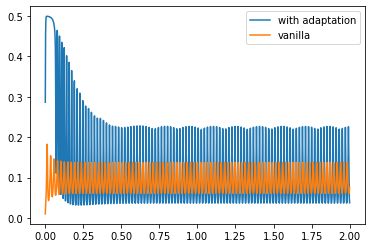

In [25]:
plt.plot(wc_adapt.t, wc_adapt.q_mean_EXC.T, label="with adaptation")
plt.plot(wc_basic.t, wc_basic.q_mean_EXC.T, label="vanilla")
plt.legend()

All done. Now we can study adaptation dynamics in Wilson-Cowan model by e.g. running exploration over adaptation parameters and eventually evolution with the target of having slow oscillations (i.e. oscillations with frequency ~1Hz) and optimising with respect to parameters such as `b`, `tauA`, `ext_input` and others. Happy hacking!